In this notebook, we demonstrate how to use the altered version of mapsims with changes made by Pedro Guicardi and Steve Choi. 
Here, we will compute maps made with noise spectra of the CCAT Prime and show the input vs. output spectrums match.

In [49]:
import sys
(sys.path).insert(1,'/Users/pedroguicardi/Desktop/CMB_Analysis/MAPSIMS/directories')

import mapsims
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from ad_fns import *
from astropy.io import fits
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ccat_models import ccat_noise as CCAT_noise
import scipy.optimize as op

In [50]:
NSIDE = 256
ell_cutoff = False
lat_lmax = 8000
cmb = mapsims.SOPrecomputedCMB(
    num=2,
    nside=NSIDE,
    lensed=False,
    aberrated=False,
    has_polarization=True,
    cmb_set=0,
    cmb_dir="mapsims/mapsims/tests/data",
    input_units="uK_CMB",
)

The way we have chosen to split the bands in the code has been by letting the following tags correspond to the following bands:
- "LC1" = (222.0, 280.0)
- "LC2" = (348.0, 405.0)
- "LC3" = (850.0, -)
Hence, it is natural to compute the maps for all 5 using the code below. 

In [56]:
chs = ["tube:LC1","tube:LC2","tube:LC3"]
noise = mapsims.SONoiseSimulator(
        nside=NSIDE,
        return_uK_CMB = True,
        sensitivity_mode = "baseline",
        apply_beam_correction = False,
        apply_kludge_correction = False,
        homogeneous=False,
        rolloff_ell = 50,
#        ell_max = lat_lmax,
        survey_efficiency = 1.0,
        full_covariance = False,
        LA_years = 5,
        LA_noise_model = "CcatLatv2b",
        elevation = 50,
        SA_years = 5,
        SA_one_over_f_mode = "pessimistic"
    )
output_maps = []
noise_maps = []
pspec_list = []
for ch in chs:
    
    
    noise_map = noise.simulate(ch[5:])
    noise_maps.append(noise_map)
    ell_sim, ps_T, ps_P, fsky, wnoise_power, weightsMap = noise.get_noise_properties(ch[5:])
    pspec_list.append(ps_T[:-1])
    
    pysm_string = "none"
    tag = pysm_string

    filename = ch[5:]+"_NSIDE_" + str(NSIDE) + "_TAG_" +"hom_"+ tag + ".fits"
    simulator = mapsims.MapSim(
        channels=ch,
        nside=NSIDE,
        unit="uK_CMB",
        pysm_output_reference_frame="C",
    #    pysm_components_string=pysm_string,
        output_filename_template = filename,
        pysm_custom_components={"cmb": cmb},
        other_components={"noise": noise},
    )
    output_map_full = simulator.execute()
    write_output_map(output_map_full,"output/"+filename)
    output_map_full = read_output_map("output/"+filename,noise, ch)
    output_maps.append(output_map_full)
    

output_maps = np.array(output_maps)
noise_maps = np.array(noise_maps).reshape(output_maps.shape)
pspec_list = np.array(pspec_list)
print(output_maps.shape)
print(noise_maps.shape)
print(pspec_list.shape)

sky config
[]
preset strings
[]
sky config
[]
preset strings
[]
sky config
[]
preset strings
[]
(3, 2, 3, 786432)
(3, 2, 3, 786432)
(3, 2, 768)


Now we apodize and plot the computed Temperature maps. 

In [58]:
output_maps = np.array([output_maps[0,0],output_maps[0,1],output_maps[1,0],output_maps[1,1],output_maps[2,0]])
noise_maps = np.array([noise_maps[0,0],noise_maps[0,1],noise_maps[1,0],noise_maps[1,1],noise_maps[2,0]])
pspec_list = np.array([pspec_list[0,0],pspec_list[0,1],pspec_list[1,0],pspec_list[1,1],pspec_list[2,0]])
det_labels = ["222.0", "280.0","348.0", "405.0","850.0"]
print(pspec_list.shape)

(5, 768)


(786432,)


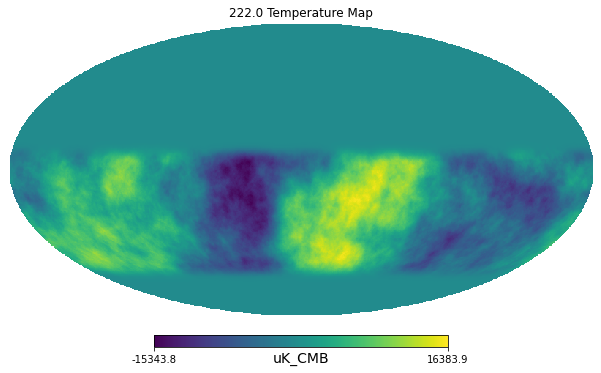

(786432,)


<Figure size 432x288 with 0 Axes>

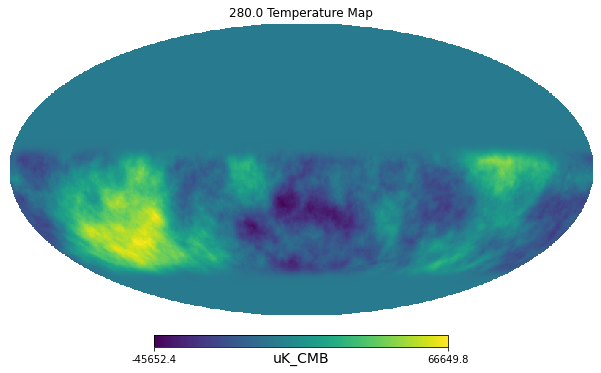

(786432,)


<Figure size 432x288 with 0 Axes>

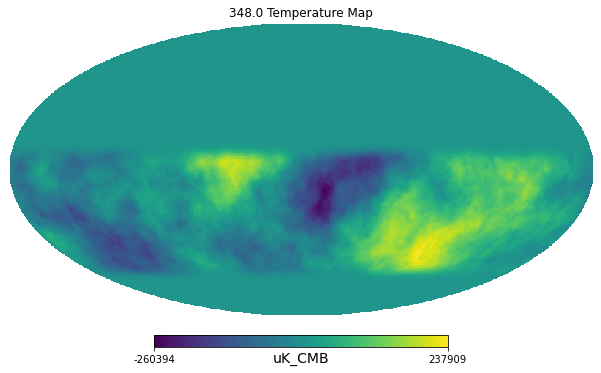

(786432,)


<Figure size 432x288 with 0 Axes>

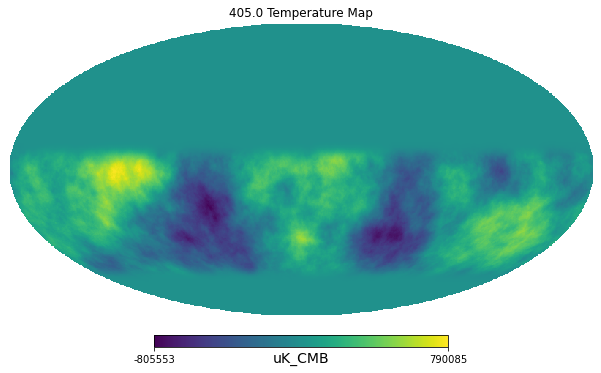

(786432,)


<Figure size 432x288 with 0 Axes>

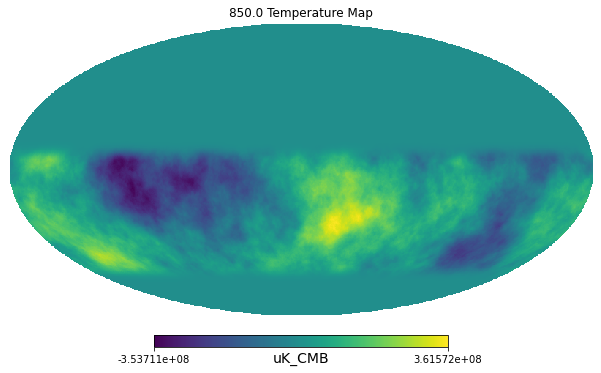

<Figure size 432x288 with 0 Axes>

In [53]:
for i in np.arange(output_maps.shape[0]):
    output_T = output_maps[i][0]
    print(output_T.shape)
    apodized_map,w = apodize_map(output_T, n_itp=5)

    hp.mollview(apodized_map, unit="uK_CMB", title = det_labels[i] +" Temperature Map")
    plt.show()
    plt.clf()


Now, we compare the input vs output power spectra.

/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 145.987664 arcmin (0.042466 rad) 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 343.774677 arcmin
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 145.987664 arcmin (0.042466 rad) 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 343.774677 arcmin
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: U

(6, 2201)


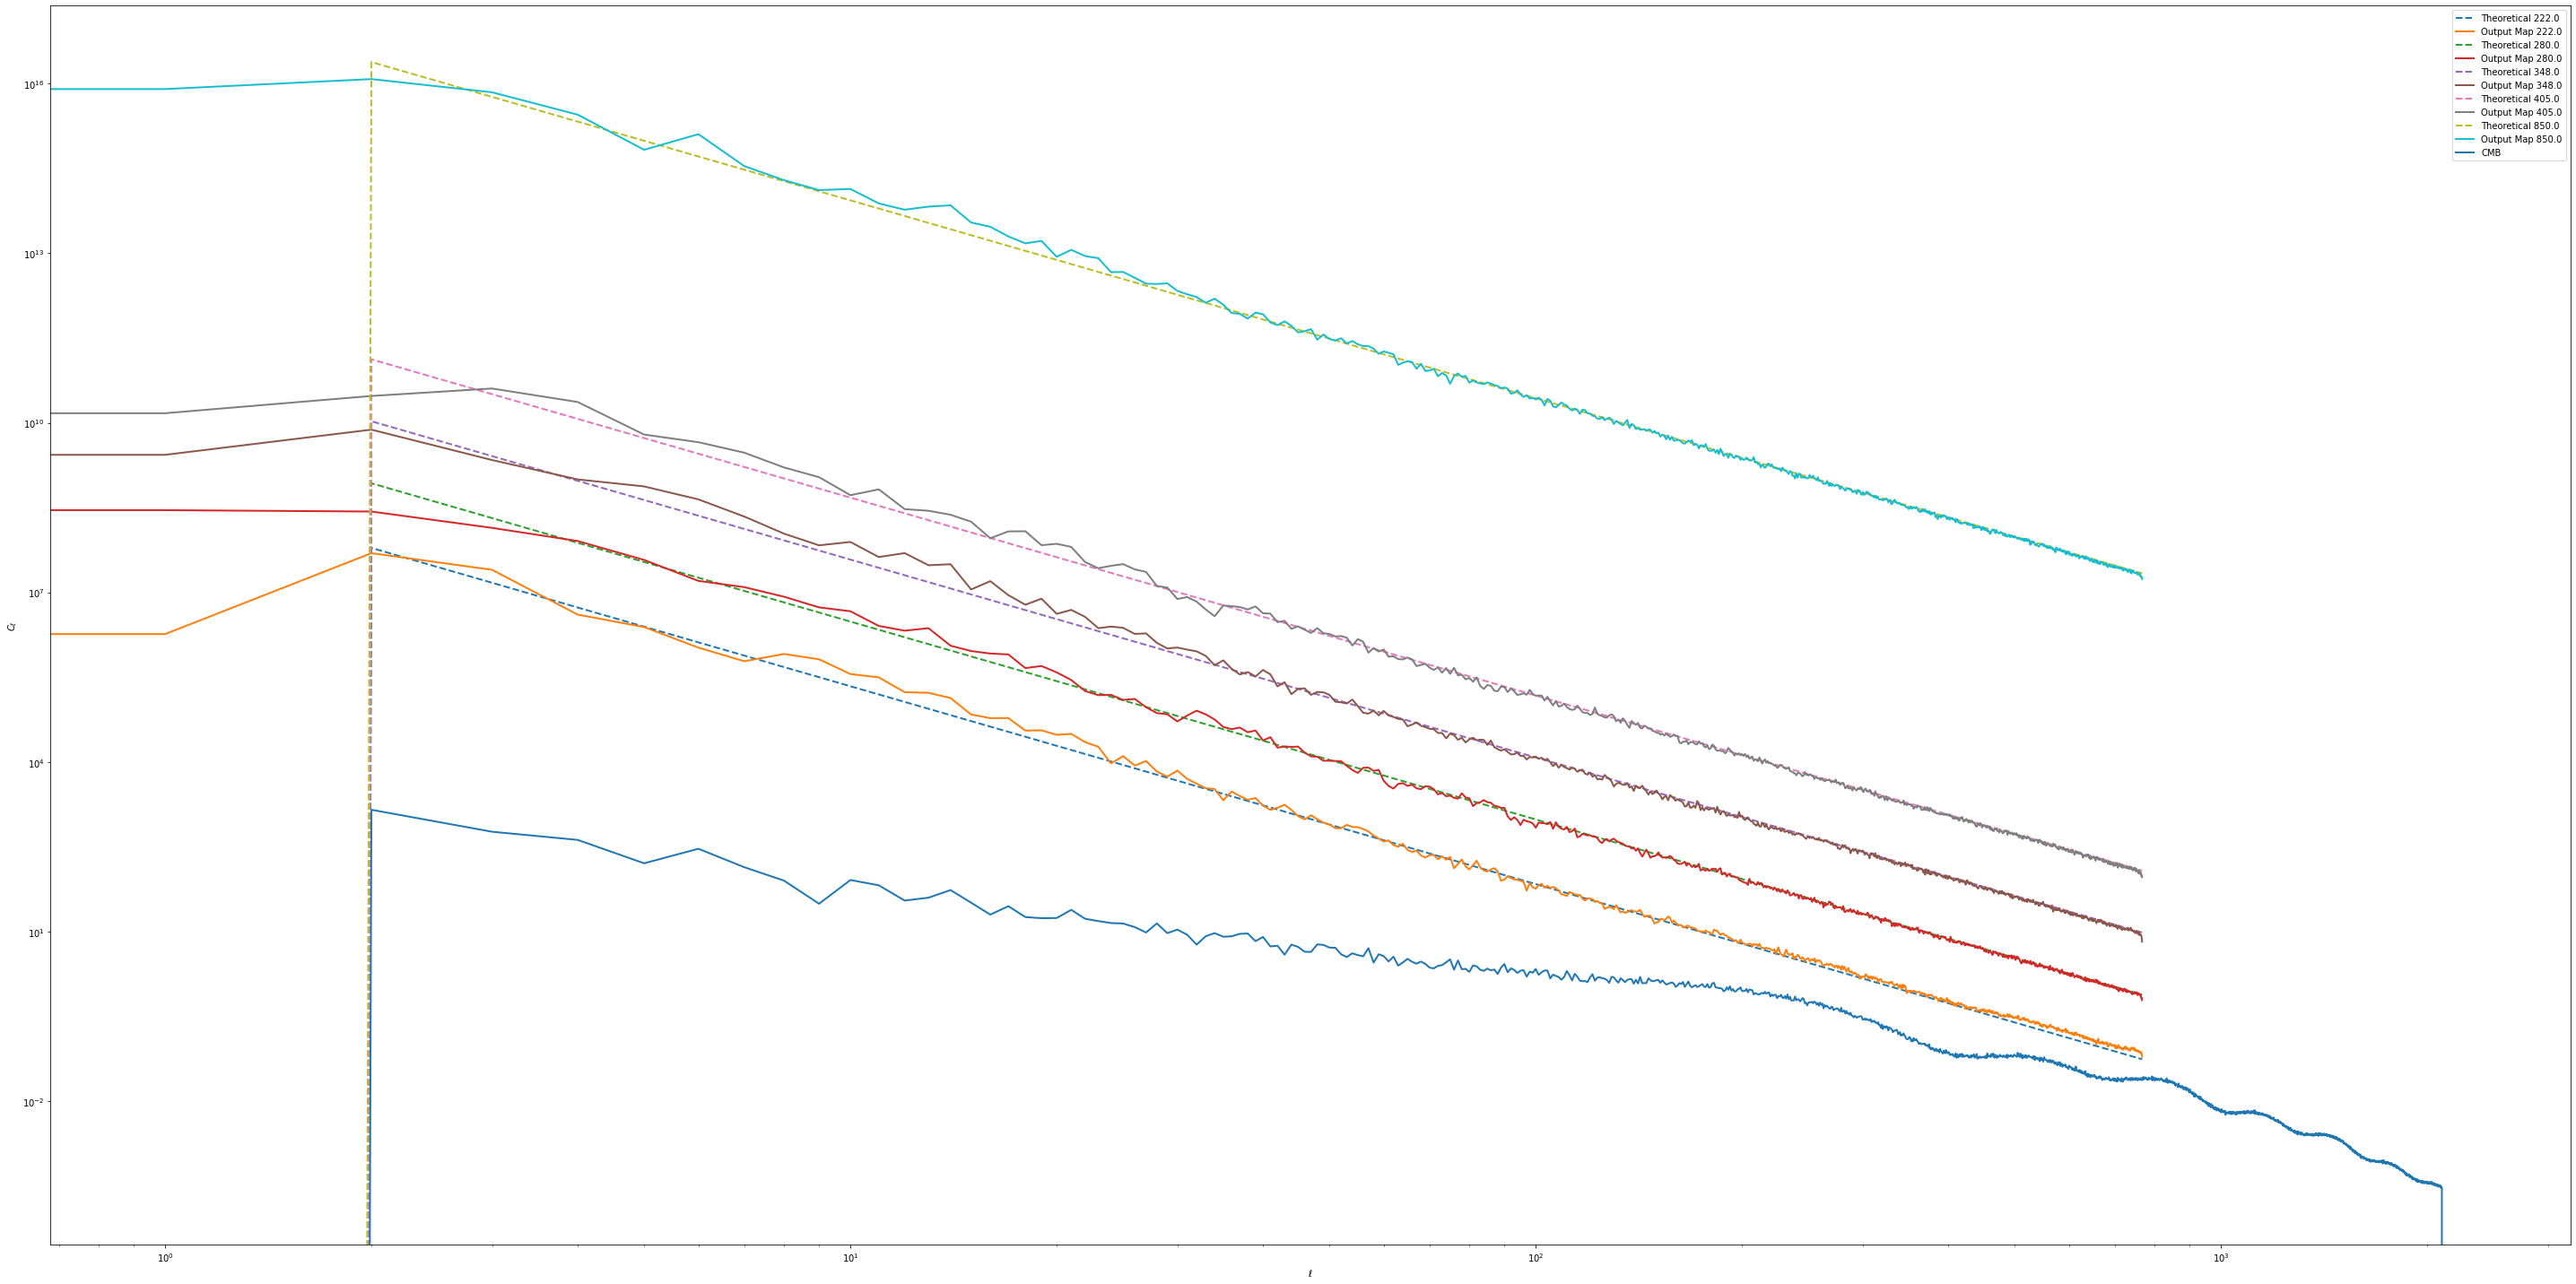

In [68]:
bands = np.array([222., 280., 348., 405., 850.])
for i in np.arange(output_maps.shape[0]):
    nm1,w1  = apodize_map(output_maps[i][0],n_itp=5)
    cls_map = hp.sphtfunc.anafast(nm1)/w1
    plt.plot(pspec_list[i],linewidth=2,label='Theoretical '+str(bands[i]),linestyle='--')
    plt.plot(cls_map,linewidth=2,label='Output Map '+str(bands[i]))
    
plt.rcParams["figure.figsize"] = (30,20)
cls_cmb = hp.alm2cl(cmb.alm)
plt.plot(cls_cmb[0],linewidth=2,label='CMB')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.show()
    

One can zoom in/ adjust the size of the figure as they wish to see the details.